In [1]:
from typing import Mapping, Sequence

import numpy as np
import pandas as pd
import polars as pl

K = 10
ndcg_weights = 1.0 / np.log2(np.arange(0, K) + 2)
ndcg_idcg = ndcg_weights.cumsum()


def evaluate(ref_path, pred_path, train_path):
    submission = pl.read_parquet(pred_path)
    ref_df = pl.read_parquet(ref_path)
    train = pl.read_parquet(train_path)

    print("Проверка столбцов в submission:")
    print(submission.columns)

    print("Проверка столбцов в ref_df:")
    print(ref_df.columns)

    # Проверка наличия необходимых столбцов
    if not {"user_id", "predicted"}.issubset(submission.columns):
        raise ValueError("В submission отсутствуют необходимые столбцы 'user_id' и/или 'predicted'.")

    if not {"user_id", "item_id"}.issubset(ref_df.columns):
        raise ValueError("В ref_df отсутствуют необходимые столбцы 'user_id' и/или 'item_id'.")

    # Обработка submissions
    submission = (
        submission
        .select(
            pl.col("user_id").cast(pl.Int64),
            pl.col("predicted").cast(pl.List(pl.Int64)).alias("predicted"),
        )
        .unique(subset="user_id")
        .with_columns(
            pl.col("predicted").list.unique(maintain_order=True)
        )
    )

    ground_truth = ref_df.with_columns(pl.col("item_id").alias("ground_truth"))

    submission_with_gt = ground_truth.join(submission, on="user_id", how="left")

    print("Проверка после объединения:")
    print(submission_with_gt.head())

    metrics_per_user = submission_with_gt.select(
        pl.col("user_id"),
        pl.struct("predicted", "ground_truth").apply(ndcg_per_user).alias("ndcg"),
    )
    mean_ndcg = metrics_per_user.select(pl.col("ndcg").mean())["ndcg"][0]

    metrics_per_user = submission_with_gt.select(
        pl.col("user_id"),
        pl.struct("predicted", "ground_truth").apply(hitrate_per_user).alias("hitrate"),
    )
    mean_hitrate = metrics_per_user.select(pl.col("hitrate").mean())["hitrate"][0]

    coverage = compute_coverage(submission, train)
    novelty = compute_novelty(submission, train)

    return {'ndcg': mean_ndcg,
            'hitrate': mean_hitrate,
            'coverage': coverage,
            'novelty': novelty}



def ndcg_per_user(pl_struct: Mapping[str, Sequence[int]]) -> float:

    predicted = pl_struct["predicted"]
    ground_truth = pl_struct["ground_truth"]

    if predicted is None:
        return 0.0

    assert ground_truth is not None
    assert len(ground_truth) > 0

    predicted_np = np.array(predicted[:K])
    ground_truth_np = np.array(ground_truth)

    predicted_count = min(len(predicted_np), K)
    gt_count = min(len(ground_truth_np), K)

    hits = (predicted_np.reshape(-1, 1) == ground_truth_np.reshape(1, -1)).sum(axis=1)
    dcg = (hits * ndcg_weights[:predicted_count]).sum()
    idcg = ndcg_idcg[gt_count - 1]
    ndcg = dcg / idcg
    return ndcg


def hitrate_per_user(pl_struct: Mapping[str, Sequence[int]]) -> float:

    predicted = pl_struct["predicted"]
    ground_truth = pl_struct["ground_truth"]

    if predicted is None:
        return 0.0

    assert ground_truth is not None
    assert len(ground_truth) > 0

    predicted_np = np.array(predicted[:K])
    ground_truth_np = np.array(ground_truth)

    hitrate = int(len(np.intersect1d(predicted_np, ground_truth_np)) > 0)

    return hitrate


def compute_coverage(submission, train):

    list_of_lists = submission.select('predicted').to_series().to_list()
    all_pred_items = [x for xs in list_of_lists for x in xs]
    all_pred_items = set(all_pred_items)

    all_train_items = train.select('item_id').unique().to_series().to_list()

    coverage = len(all_pred_items.intersection(all_train_items)) / len(all_train_items)

    return coverage


def compute_novelty(submission, train):

    num_interactions = len(train)
    item_stats = train.groupby('item_id').count()
    item_stats = item_stats.with_columns(-np.log2(pl.col('count') / num_interactions).alias('item_novelty'))
    item_stats = item_stats.with_columns((pl.col('item_novelty') / np.log2(num_interactions)))
    item_stats = item_stats.select('item_id', 'item_novelty').to_pandas()

    list_of_lists = submission.select('predicted').to_series().to_list()
    all_pred_items = [x for xs in list_of_lists for x in xs]
    num_recommendations = len(all_pred_items)

    recs_items = pd.Series(all_pred_items).value_counts().reset_index()
    recs_items.columns = ['item_id', 'item_count']
    recs_items = pd.merge(recs_items, item_stats)
    recs_items['product'] = recs_items['item_count'] * recs_items['item_novelty']

    novelty = recs_items['product'].sum() / num_recommendations

    return novelty

In [2]:
import pandas as pd
from datetime import datetime

smm_train = pd.read_parquet("./train_smm.parquet")
#smm_train["timestamp_readable"] = pd.to_datetime(smm_train["timestamp"] // 1e6, unit="ms")
smm_test = pd.read_parquet("./test_smm.parquet")

In [3]:
import hashlib

unique_user_ids = smm_train['user_id'].unique()

user_hashes = [hashlib.md5(str(uid).encode()).hexdigest() for uid in unique_user_ids]

user_hash_df = pd.DataFrame({
    'user_id': unique_user_ids,
    'hash_md5': user_hashes
})

selected_user_ids = user_hash_df.sort_values('hash_md5')['user_id'].head(5000)

filtered_df = smm_train[smm_train['user_id'].isin(selected_user_ids)]

In [4]:
filtered_test = smm_test[smm_test['user_id'].isin(selected_user_ids)].copy()

In [5]:
filtered_df

,user_id,item_id,timestamp,rating
47,3187113,93477,1673740918670000000,1.554808
224,9775359,119733,1673741297372000000,1.554808
250,9775359,159019,1673741359343000000,1.554808
578,4631898,45438,1673741911000000000,2.802427
579,4631898,52823,1673741911000000000,11.209706
...,...,...,...,...
20689396,4689573,19660,1682414020243000000,1.554808
20689403,2796588,82570,1682414021348000000,1.554808
20689417,9323870,162710,1682414025341000000,1.554808
20689432,4509459,92335,1682414028438000000,1.554808


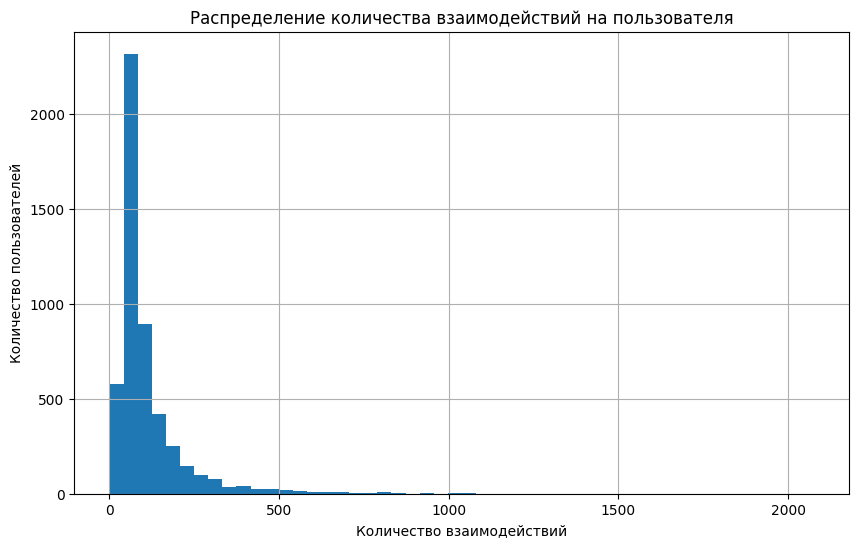

In [8]:
import matplotlib.pyplot as plt

# Расчет количества взаимодействий на пользователя
user_interactions = filtered_df.groupby('user_id').size()

# Построение гистограммы распределения
plt.figure(figsize=(10,6))
user_interactions.hist(bins=50)
plt.xlabel('Количество взаимодействий')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества взаимодействий на пользователя')
plt.show()

In [9]:
# Вычисление перцентилей
percentiles = user_interactions.quantile([0.25, 0.33, 0.5, 0.66, 0.75, 0.99])
print(percentiles)

0.25     54.00
0.33     60.00
0.50     74.00
0.66    100.00
0.75    123.00
0.99    647.02
dtype: float64


In [10]:
from ration_splitter import RatioSplitter

filtered_df.rename(columns={"user_id": "query_id"}, inplace=True)

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15
random_state = 42

splitter = RatioSplitter(
    test_size = 0.2,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column='query_id',
    item_column='item_id',
    timestamp_column='timestamp'
)

(train_data, val_data), cold_users, cold_items = splitter.split(filtered_df)


C:\Temp\ipykernel_636\2911076759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={"user_id": "query_id"}, inplace=True)


In [11]:
from lightfm import LightFM
from lightfm.data import Dataset

dataset = Dataset()

unique_users = train_data['query_id'].unique()
unique_items = train_data['item_id'].unique()

dataset.fit(unique_users, unique_items)

(interactions, weights) = dataset.build_interactions(
    ((row['query_id'], row['item_id']) for index, row in train_data.iterrows())
)

model = LightFM(no_components=30, loss='warp', random_state=42)
model.fit(interactions, epochs=30, num_threads=4)


ModuleNotFoundError: No module named 'lightfm'